# Uncertainty-aware Deep Learning with SNGP


In AI applications that are safety-critical, or where data is inherently noisy, it's important for a model to be able to reliably quantify its uncertainty. The deep classifier should be able to recognize its own limitations and when to give control to human experts.

We will improve a deep classifier's (ResNet) ability to quantify uncertainty using **Spectral-normalized Neural Gaussian Process ([SNGP](https://arxiv.org/abs/2006.10108))**

The idea behind SNGP is to improve a deep classifier's *distance awareness* by applying simple modifications to the network. A model's _distance awareness_ is a measure of how its predictive probability reflects the distance between the test example and the training data. This property is evident in models such as Guassian process with RBF kernals, but lacking in deep nerual networks. With SNGP we can inject Guassian-process behaviour into a deep classifier while maining its predictive accuracy. 

We will implement a deep residual network (ResNet)-based SNGP model on the [two moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset, and compares its uncertainty surface with that of two other popular uncertainty approaches - [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) and [Deep ensemble](https://arxiv.org/abs/1612.01474)).

## SNGP

[Spectral-normalized Neural Gaussian Process](https://arxiv.org/abs/2006.10108)  (SNGP) is a simple approach to improve a deep classifier's uncertainty quality while maintaining a similar level of accuracy and latency. Given a deep residual network, SNGP makes two simple changes to the model:

* It applies spectral normalization to the hidden residual layers.
* It replaces the Dense output layer with a Gaussian process layer.

<img src="https://www.tensorflow.org/tutorials/understanding/images/sngp.png" />

Relative to other uncertainty approaches, SNGP offers advantages such as:
- Works for wide range of resisual based architectures
- Is a single-model method; doesn't rely on ensemble averaging
- Has strong out-of-domain detection performance due to *distance-awareness* property

However, this approach carries a few disadvantages such as:
- The predictive uncertainty of a SNGP is computed using the [Laplace approximation](http://www.gaussianprocess.org/gpml/chapters/RW3.pdf). Therefore theoretically, the posterior uncertainty of SNGP is different from that of an exact Gaussian process.
- SNGP training requires a covariance reset step at the beginning of a new epoch

### Setup

In [44]:
!pip install tf-models-nightly

In [45]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as nlp_layers

In [46]:
#visualization constants
plt.rcParams['figure.dpi'] = 140
DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

### Dataset

We will preprocess training and testing sets from the [two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

Training data helper function:

In [47]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

Helper function to evaluate model's predictive behvaiour over 2D space:

In [48]:
def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

To evaluate model uncertainty, add an out-of-domain (OOD) dataset that belongs to a third class. The model never sees these OOD examples during training:

In [49]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

Load training, testing and OOD datasets:

In [50]:
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

Visualize data:

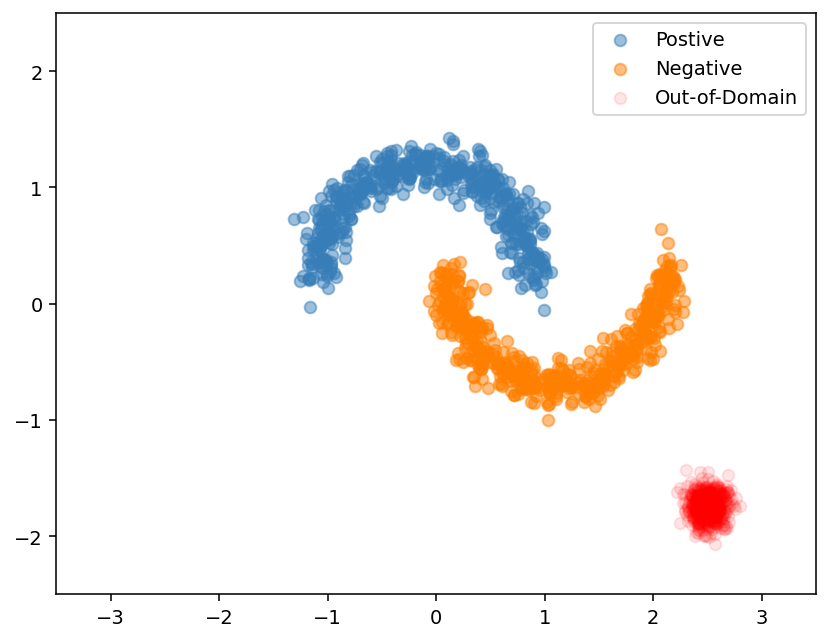

In [51]:
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

A model that quantifies the uncertainty well is expected to be confident when close to training data  (i.e., $p(x_{test})$ close to 0 or 1), and be uncertain when far away from the training data regions  (i.e., $p(x_{test})$ close to 0.5).

## Deterministic Model

### Model Definition
The baseline model will be a multi-layer residual network (ResNet) with Dropout regularization:


In [52]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs
    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]
    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)
    # Computes the resnet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid
    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

We will use a 6-layer ResNet with 128 hidden units:

In [53]:
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128) #config
resnet_model = DeepResNet(**resnet_config)  #model instantiation
resnet_model.build((None, 2))       #model build
resnet_model.summary()      #model visualization


Model: "deep_res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             multiple                  384       
_________________________________________________________________
dense_39 (Dense)             multiple                  16512     
_________________________________________________________________
dense_40 (Dense)             multiple                  16512     
_________________________________________________________________
dense_41 (Dense)             multiple                  16512     
_________________________________________________________________
dense_42 (Dense)             multiple                  16512     
_________________________________________________________________
dense_43 (Dense)             multiple                  16512     
_________________________________________________________________
dense_44 (Dense)             multiple               

### Train the Model

We use an Adam optimizer with `SpareCategoricalCrossentropy` as our loss function

In [54]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

Train model for 100 epochs, with batch size 128:

In [55]:
fit_config = dict(batch_size=128, epochs=100)

In [56]:
resnet_model.compile(**train_config)
resnet_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100
8/8 [==============================] - 1s 9ms/step - loss: 0.5537 - sparse_categorical_accuracy: 0.6980
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.3074 - sparse_categorical_accuracy: 0.8860
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.2076 - sparse_categorical_accuracy: 0.9180
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.9360
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.9290
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.9450
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.9460
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9420
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 0

Visualize the uncertainty:

In [57]:

def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.
  
  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).
  
  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

Visualize the predictions of the deterministic model. Plot the class probability $$p(x) = softmax(logit(x))$$

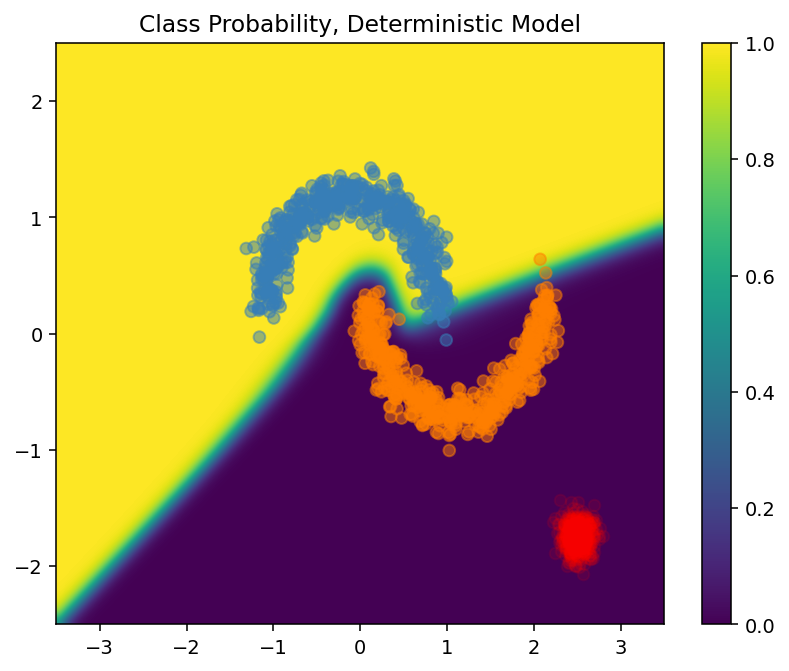

In [58]:
resnet_logits = resnet_model(test_examples)
resnet_probs = tf.nn.softmax(resnet_logits, axis=-1)[:, 0]  # Take the probability for class 0.

_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs, ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")
plt.show()

In this plot, the yellow and purple regions represent the predictive probabilities for the 2 classes. The deterministic model did well at classifying the 2 known classes (blue and orange), with a non-linear decision boundary. However, this model is not *distance-aware*, and classified the never-seen red OOD examples confidently as the orange class.

Visualize the model uncertainty by computing the [predictive variance](https://en.wikipedia.org/wiki/Bernoulli_distribution#Variance):
$$var(x) = p(x) * (1 - p(x))$$

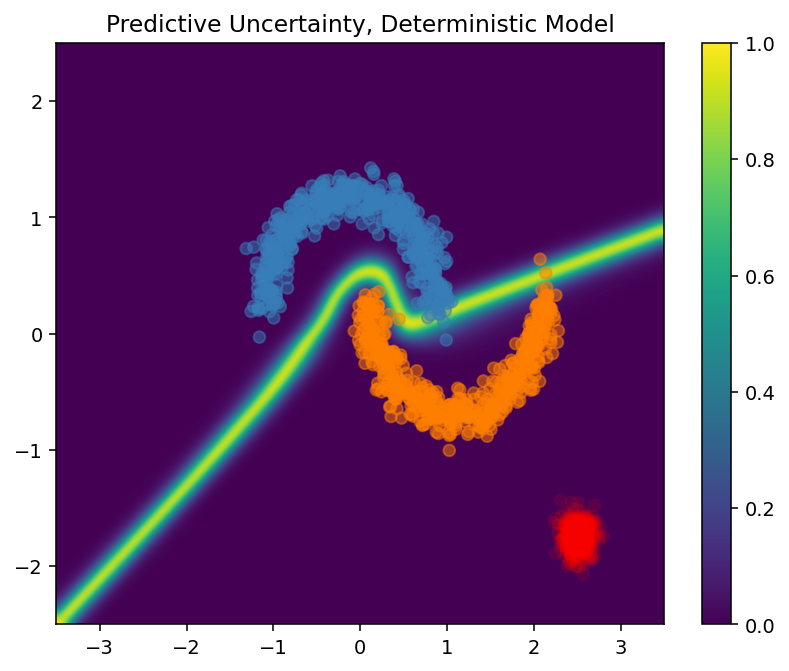

In [59]:
resnet_uncertainty = resnet_probs * (1 - resnet_probs)

_, ax = plt.subplots(figsize=(7, 5.5))
pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")
plt.show()

In this plot, yellow and purple indicate high uncertainty and low uncertainty, respectively. The deterministic ResNet's uncertainty depends only on the test examples' distance from the decision boundary. As a result, the model will be over-confident for data outside the training domain.

We can improve our model's awareness with SNGP

### SNGP Model

#### Model Definition
Both the SNGP components, `SpectralNormalization` and `RandomFeatureGaussianProcess`, are available at the tensorflow_model's [built-in  layers](https://github.com/tensorflow/models/tree/master/official/nlp/modeling/layers). 

##### Spectral Normalization Wrapper

Spectral normalization regularizes the hidden weight $W$ by gradually guiding its spectral norm (ie largest eigenvalue of $W$) toward the target value `norm_multiplier` which is provided as a parameter.

##### Guassian Process (GP) Layer

`RandomFeatureGuassianProcess` implements a [random-feature based approximation](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) to a Gaussian process model that is end-to-end trainable with a deep neural network. Under the hood, the Gaussian process layer implements a two-layer network:

$$logits(x) = \Phi(x) \beta, \quad \Phi(x)=\sqrt{\frac{2}{M}} * cos(Wx + b)$$

where $x$ is the input, $W$ and $b$ are frozen weights initialized randomly from Guassian and uniform distributions, respectively. Hence $\Phi(x)$ is a "random feature" and $\beta$ si a learnable kernal weight.

Given a batch input with shape `(batch_size, input_dim)`, the GP layer returns a `logits` tensor (shape `(batch_size, num_classes)`) for prediction, and also  `covmat` tensor (shape `(batch_size, batch_size)`) which is the posterior covariance matrix of the batch logits.

Note that under this implementation of the SNGP model, the predictive logits $logit(x_{test})$ for all classes share the same covariance matrix $var(x_{test})$, which describes the distance between $x_{test}$ from the training data. 

Theoretically, it is possible to extend the algorithm to compute different variance values for different classes (as introduced in the [original SNGP paper](https://arxiv.org/abs/2006.10108)). However, this is difficult to scale to problems with large output spaces (e.g., ImageNet or language modeling).

#### Full SNGP Model

Using the base class `DeepResNet`, we can implement the SNGP model by modifying the residual network's hidden and output layers. 

To make the model compatible with keras `model.fit()`, we modify the `call()` method to only output logits during training.

In [60]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes, 
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and covariance matrix from GP layer.
    logits, covmat = super().call(inputs)
    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

Instantiate a SNGP model with the base `DeepResNet` using the same architecture with the deterministic ResNet model.

In [61]:
sngp_model = DeepResNetSNGP(**resnet_config)
sngp_model.build((None, 2))
sngp_model.summary()

Model: "deep_res_net_sngp_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             multiple                  384       
_________________________________________________________________
spectral_normalization_26 (  multiple                  16768     
SpectralNormalization)                                           
_________________________________________________________________
spectral_normalization_27 (  multiple                  16768     
SpectralNormalization)                                           
_________________________________________________________________
spectral_normalization_28 (  multiple                  16768     
SpectralNormalization)                                           
_________________________________________________________________
spectral_normalization_29 (  multiple                  16768     
SpectralNormalization)                         

Callback method to reset covariance matrix at start of each new epoch. Then add this callback to the `DeepResNetSNGP model class`:

In [62]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the begining of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)     

Train model:

In [63]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
sngp_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100
8/8 [==============================] - 2s 19ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.9040
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.5455 - sparse_categorical_accuracy: 0.9760
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.4926 - sparse_categorical_accuracy: 0.9970
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.4534 - sparse_categorical_accuracy: 0.9990
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.4220 - sparse_categorical_accuracy: 0.9980
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.3965 - sparse_categorical_accuracy: 0.9990
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 0.3699 - sparse_categorical_accuracy: 0.9990
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 0.3492 - sparse_categorical_accuracy: 0.9980
Epoch 9/100
8/8 [==============================] - 0s 19ms/step 

### Visualize Uncertainty

Compute predictive logits and variances:

In [64]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

Compute posterier predictive probability. A typical method for computing predictive probability of a probabilistic model is to use Monte Carlo sampling ie 
$$E(p(x)) = \frac{1}{M} \sum_{m=1}^M logit_m(x), $$

where $M$ is the sample size, and $logit_m(x)$ are random samples from the SNGP posterior $MultivariateNormal$(`sngp_logits`,`sngp_covmat`). However, this approach can be slow for latency-sensitive applications such as autonomous driving or real-time bidding. 

Alternatively, we can approximate $E(p(x))$ using the [mean-field method](https://arxiv.org/abs/2006.07584):

$$E(p(x)) \approx softmax(\frac{logit(x)}{\sqrt{1+ \lambda * \sigma^2(x)}})$$

where $\sigma^2(x)$ is the SNGP variance, and $\lambda$ is often chosen as $\pi/8$ or $3/\pi^2$.

In [65]:
sngp_logits_adjusted = sngp_logits / tf.sqrt(1. + (np.pi / 8.) * sngp_variance)
sngp_probs = tf.nn.softmax(sngp_logits_adjusted, axis=-1)[:, 0]

Note: we can use [temperature scaling](http://proceedings.mlr.press/v70/guo17a.html) on $\lambda$ to further improve the model's performance (ie treate $\lambda$ as a hyperparam and tune it)

This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:

In [66]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)
  
  return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [67]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

### SNGP Summary

Helper function to plot prediction probabilities and predictive uncertainties:

In [68]:
def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))
  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])
  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])
  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")
  plt.show()  

Helper function for end-to-end analysis (training, evaluation, uncertainty computation):

In [69]:
def train_and_test_sngp(train_examples, test_examples):
  sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

  sngp_model.compile(**train_config)
  sngp_model.fit(train_examples, train_labels, verbose=0, **fit_config)

  sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

  return sngp_probs

In [70]:
sngp_probs = train_and_test_sngp(train_examples, test_examples)

Visualize class probability (left) and predictive uncertainty (right) of SNGP model:

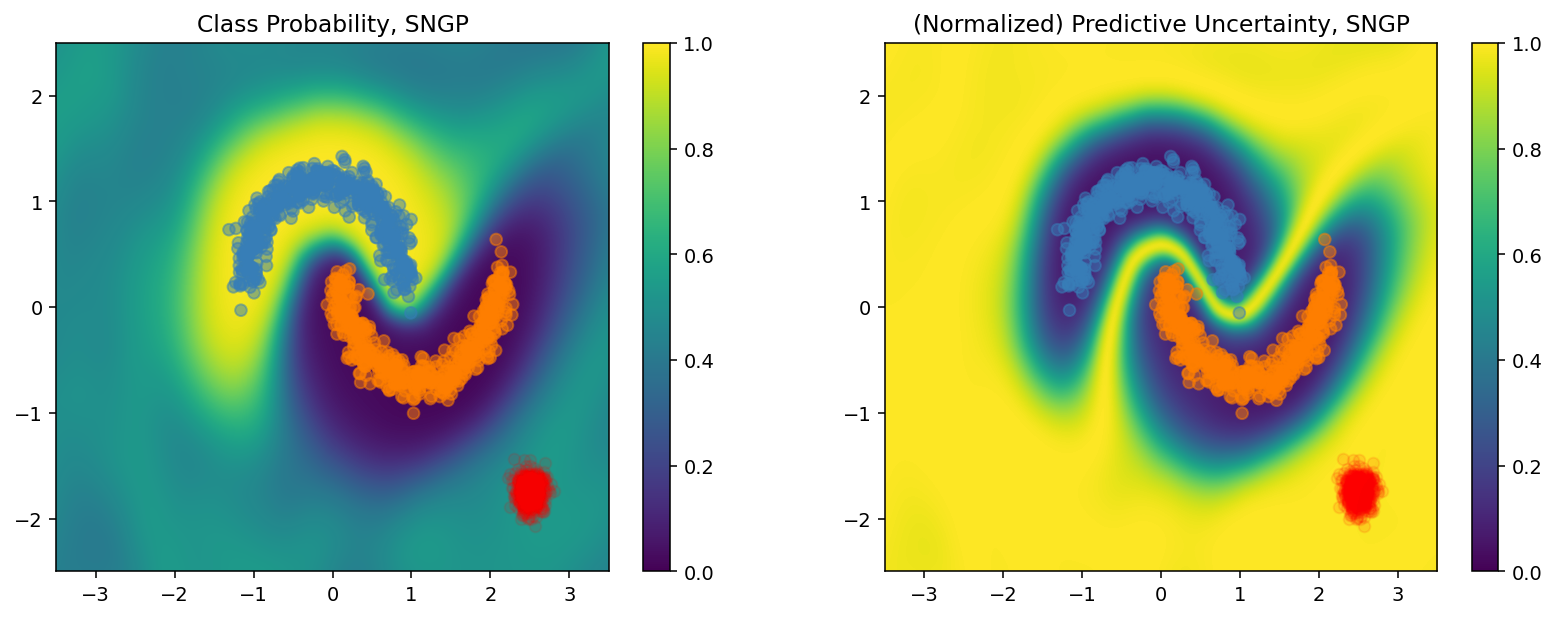

In [71]:
plot_predictions(sngp_probs, model_name="SNGP")

Consider the plots above. When close to the training data domain, SNGP correctly classifies the examples with high confidence (i.e., assigning near 0 or 1 probability). When far away from the training data, SNGP gradually becomes less confident, and its predictive probability becomes close to 0.5 while the (normalized) model uncertainty rises to 1.

Compare this to the uncertainty surface of the deterministic model, where we saw the class probabilities were either very close to 1 or 0 and between only in the thin decision boundary between the training set positive (1) and negative (0) examples, and the predictive uncertainty was very low in these non-decision boundary regions. 


Due to the *distance-aware* property, the SNGP model was able to recognize OOD examples and output high predictive uncertainty.

### Comparison with other Uncertainty Approaches

Let's compare the uncertainty performance of SNGP with [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) and [Deep ensemble](https://arxiv.org/abs/1612.01474)

Both of these methods are based on Monte Carlo averaging of multiple forward passes of deterministic models. First set the ensemble size $M$.

In [72]:
num_ensemble = 10

#### Monte Carlo Dropout

Given a trained neural network with Dropout layers, [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) computes the mean predictive probability 

$$E(p(x)) = \frac{1}{M}\sum_{m=1}^M softmax(logit_m(x))$$ 

by averaging over multiple Dropout-enabled forward passes $\{logit_m(x)\}_{m=1}^M$.

In [73]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

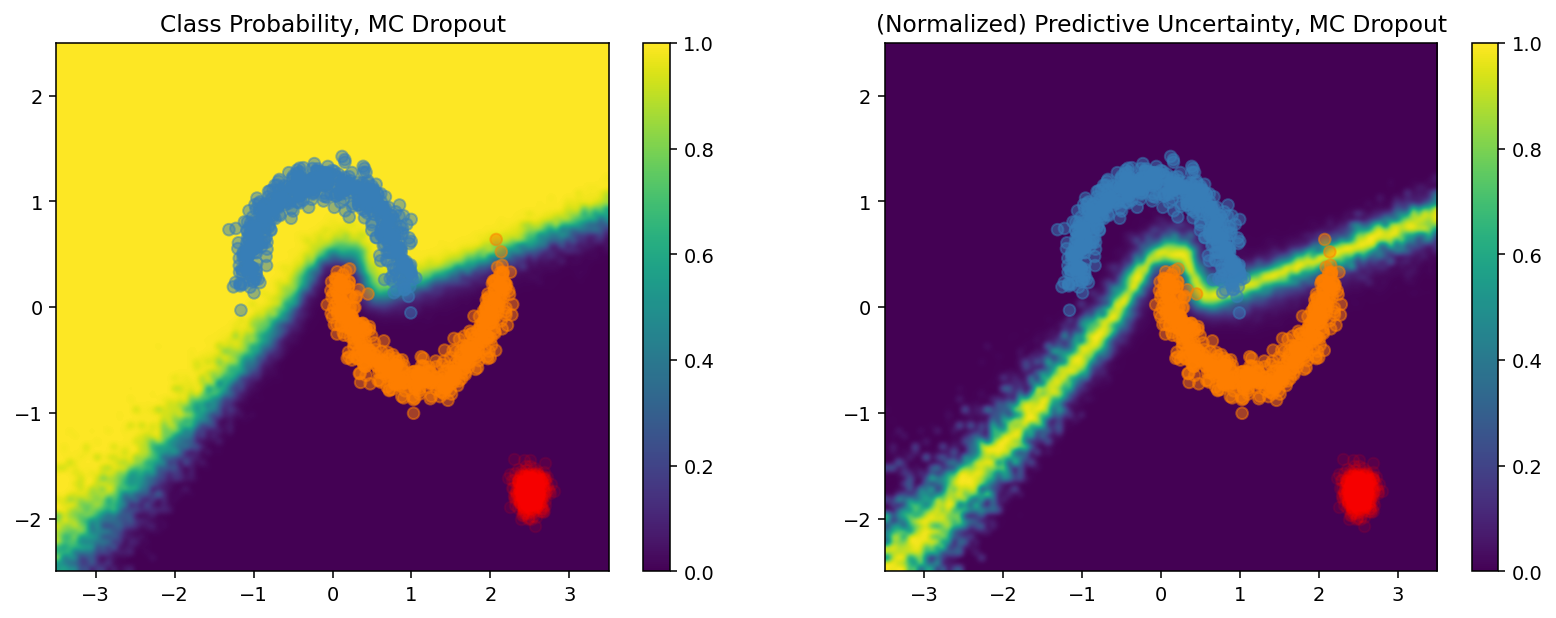

In [80]:
# Monte Carlo dropout inference.
dropout_logit_samples = [mc_dropout_sampling(test_examples) for _ in range(num_ensemble)]
dropout_prob_samples = [tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

plot_predictions(dropout_probs, model_name="MC Dropout")

#### Deep Ensemble

[Deep ensemble](https://arxiv.org/abs/1612.01474) is a state-of-the-art (but expensive) method for deep learning uncertainty. To train a Deep ensemble, first train $M$ ensemble members.

In [81]:
# Deep ensemble training
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(train_examples, train_labels, verbose=0, **fit_config)  

  resnet_ensemble.append(resnet_model)

Then, collect logits and compute mean predictive probability
$$E(p(x)) = \frac{1}{M}\sum_{m=1}^M softmax(logit_m(x))$$

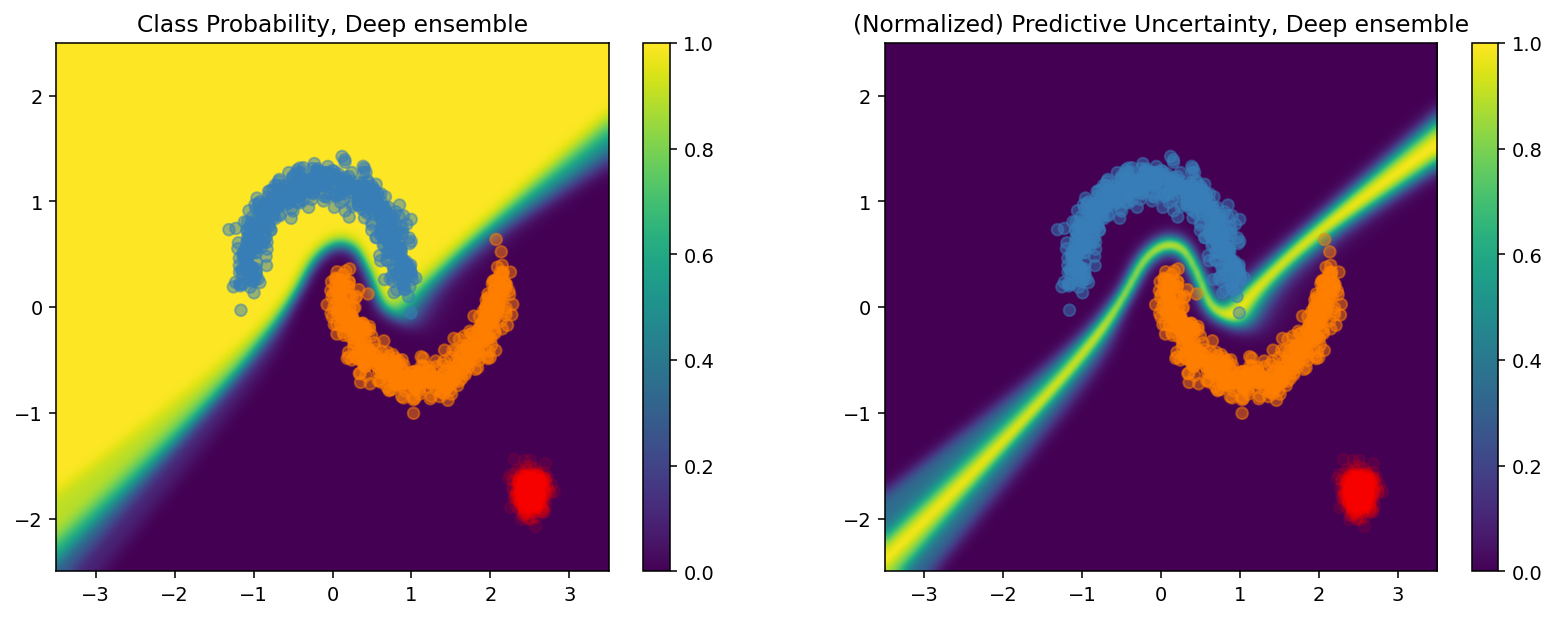

In [83]:
# Deep ensemble inference
ensemble_logit_samples = [model(test_examples) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

plot_predictions(ensemble_probs, model_name="Deep ensemble")

### Summary

We see that both MC Dropout and Deep ensemble improve the model's uncertainty ability by making the decision boundary less certain, but they both inherit the deterministic deep network's limitation in lacking *distance awareness*.

However, SNGP improves a model's distance awareness to a much higher degree, so that the model can reliably detect OOD examples and output a high predictive uncertainty, hence allowing users to be aware of when human attention is required for an example.